Loading MNIST dataset
Normalizing data
Splitting data into train and test sets
Epoch 1/20, Loss: 0.050336
Epoch 2/20, Loss: 0.019367
Epoch 3/20, Loss: 0.014543
Epoch 4/20, Loss: 0.012247
Epoch 5/20, Loss: 0.010798
Epoch 6/20, Loss: 0.009810
Epoch 7/20, Loss: 0.009063
Epoch 8/20, Loss: 0.008450
Epoch 9/20, Loss: 0.007947
Epoch 10/20, Loss: 0.007502
Epoch 11/20, Loss: 0.007145
Epoch 12/20, Loss: 0.006771
Epoch 13/20, Loss: 0.006501
Epoch 14/20, Loss: 0.006235
Epoch 15/20, Loss: 0.006050
Epoch 16/20, Loss: 0.005821
Epoch 17/20, Loss: 0.005651
Epoch 18/20, Loss: 0.005488
Epoch 19/20, Loss: 0.005351
Epoch 20/20, Loss: 0.005181


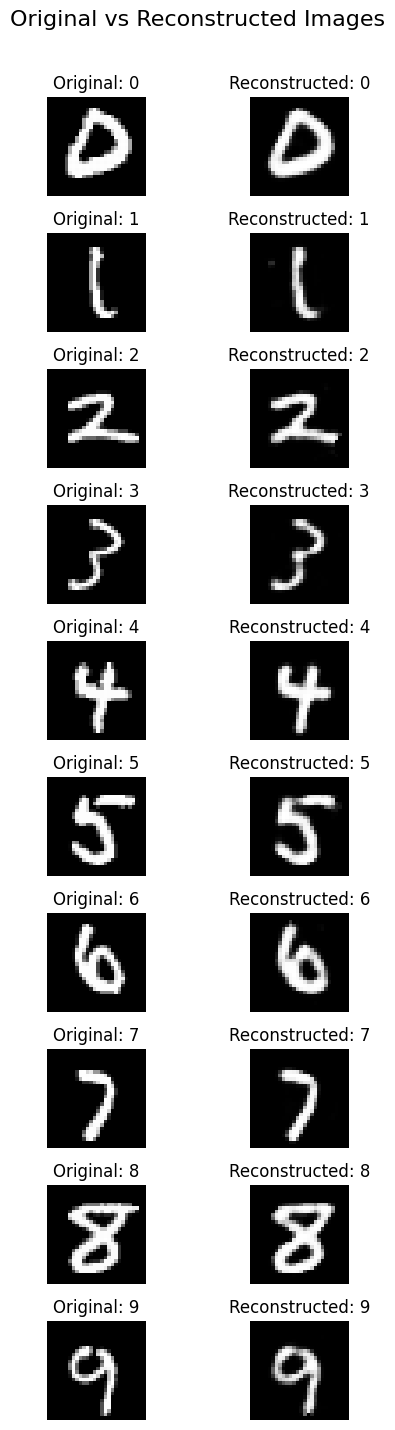

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

class Module:

  def __init__(self):
    self._parameters = {}
    self._gradients = {}
    self.training = True

  def forward(self , *args , **kwargs):
    raise NotImplementedError

  def backward(self , *args , **kwargs):
    raise NotImplementedError

  def parameters(self):

    params = []
    for name , param in self._parameters.items():
        if param is not None:
          params.append(param)

    for attr_name in dir(self):
        attr = getattr(self , attr_name)
        if isinstance(attr , Module):
          params.extend(attr.parameters())
    return params

  def gradients(self):
    grads = []
    for name , grad in self._gradients.items():
      if grad is not None:
        grads.append(grad)

    for attr_name in dir(self):
      attr = getattr(self , attr_name)
      if isinstance(attr , Module):
        grads.extend(attr.gradients())
    return grads

  def train(self):

    self.training = True
    for attr_name in dir(self):
      attr = getattr(self , attr_name)
      if isinstance(attr , Module):
        attr.train()

  def eval(self):

    self.training = False
    for attr_name in dir(self):
      attr = getattr(self , attr_name)
      if isinstance(attr , Module):
        attr.eval()

class Linear(Module):

  def __init__(self, in_features , out_features , bias = True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features

    limit = np.sqrt(6 / (in_features + out_features))
    self.weights = np.random.uniform(-limit , limit , (in_features ,out_features))
    self._parameters['weights'] = self.weights
    self._gradients['weights'] = np.zeros_like(self.weights)


    self.bias = None
    if bias:
      self.bias = np.zeros(out_features)
      self._parameters['bias'] = self.bias
      self._gradients['bias'] = np.zeros_like(self.bias)

    self.input = None

  def forward(self , x):
    self.input = x
    output = x @ self.weights
    if self.bias is not None:
      output += self.bias
    return output

  def backward(self , grad_output):
    self._gradients['weights'] = self.input.T @ grad_output
    if self.bias is not None:
      self._gradients['bias'] = np.sum(grad_output , axis = 0)

    grad_input = grad_output @ self.weights.T
    return grad_input

class Sequential(Module):

  def __init__(self , *layers):
    super().__init__()
    self.layers = list(layers)
    for i , layer in enumerate(self.layers):
      setattr(self , f'layer_{i}' , layer)

  def forward(self , x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self , grad_output):
    for layer in reversed(self.layers):
      grad_output = layer.backward(grad_output)
    return grad_output


class ReLU(Module):

  def __init__(self):
    super().__init__()
    self.input = None

  def forward(self , x):
    self.input = x
    return np.maximum(0,x)

  def backward(self , grad_output):
    return np.multiply(grad_output , self.input > 0)

class Sigmoid(Module):

  def __init__(self):
    super().__init__()
    self.input = None

  def forward(self , x):
    self.output = 1 / (1 + np.exp(-x))
    return self.output

  def backward(self , grad_output):
    return np.multiply(grad_output , self.output * (1 - self.output))


class MSELoss(Module):

  def __init__(self):
    super().__init__()
    self.pred = None
    self.target = None

  def forward(self , pred , target):
    self.pred = pred
    self.target = target
    return np.mean((pred - target) ** 2)

  def backward(self , grad_output):
    n = self.target.shape[0] * self.target.shape[1]
    grad_input =  2 * (self.pred - self.target) / n
    return grad_input

class Adam:

  def __init__(self , params ,lr = 0.001 , beta1 = 0.9 , beta2 = 0.999 , epsilon = 1e-8):

    self.params = [p for p in params]
    self.grads = [np.zeros_like(p) for p in self.params]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.t = 0

    self.m = [np.zeros_like(p) for p in self.params]
    self.v = [np.zeros_like(p) for p in self.params]

  def zero_grad(self):
    for g in self.grads:
      g.fill(0)

  def step(self , model_grads):

    self.t += 1
    for i , (param, grad) in enumerate(zip(self.params ,model_grads)):
      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

      m_hat = self.m[i] / (1 - self.beta1 ** self.t)
      v_hat = self.v[i] / (1 - self.beta2 ** self.t)


      self.params[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)


class MLPAutoencoder(Module):

  def __init__(self , input_dim = 784,latent_dim= 64):

    super().__init__()

    self.encoder = Sequential(
      Linear(input_dim , 256),
      ReLU(),
      Linear(256 , 128),
      ReLU(),
      Linear(128 , latent_dim)
    )

    self.decoder = Sequential(
      Linear(latent_dim , 128),
      ReLU(),
      Linear(128 , 256),
      ReLU(),
      Linear(256 , input_dim),
      Sigmoid()
    )


  def forward(self , x):
    encoded = self.encoder.forward(x)
    decoded = self.decoder.forward(encoded)
    return decoded

  def backward(self , grad_output):
    grad_encoded = self.decoder.backward(grad_output)
    grad_input = self.encoder.backward(grad_encoded)
    return grad_input


def load_and_prep_mnist():

  print("Loading MNIST dataset")
  mnist = fetch_openml('mnist_784', version=1 ,as_frame = False, parser = 'auto')
  X = mnist.data.astype('float32')
  y = mnist.target.astype('int64')

  print("Normalizing data")
  X /= 255.0

  print("Splitting data into train and test sets")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test


def train_autoencoder(model , X_train , epochs = 20 , batch_size = 256 , lr = 1e-3):

  criterion = MSELoss()
  optimizer = Adam(model.parameters() , lr = lr)

  model.train()

  n_samples = X_train.shape[0]
  n_batches = n_samples // batch_size

  for epoch in range(epochs):
    epoch_loss = 0.0

    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train[permutation]

    for i in range(n_batches):
      start_idx = i * batch_size
      end_idx = start_idx + batch_size

      X_batch = X_train_shuffled[start_idx : end_idx]

      reconstructed  = model.forward(X_batch)
      loss = criterion.forward(reconstructed , X_batch)

      grad_input = criterion.backward(1.0)
      model.backward(grad_input)

      optimizer.step(model.gradients())
      optimizer.zero_grad()

      epoch_loss += loss

    avg_loss = epoch_loss / n_batches
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")


def visualize_reconstructions(model , X_test , y_test):

  model.eval()

  fig,axes = plt.subplots(10,2,figsize = (5,15))
  fig.suptitle("Original vs Reconstructed Images" , fontsize = 16)

  for i in range(10):

    digit_idx = np.where(y_test == i)[0][0]
    original_img = X_test[digit_idx]

    original_img_batch = original_img.reshape(1,-1)

    reconstructed_img = model.forward(original_img_batch).flatten()

    axes[i,0].imshow(original_img.reshape(28,28) , cmap = 'gray')
    axes[i,0].set_title(f"Original: {i}")
    axes[i,0].axis('off')

    axes[i,1].imshow(reconstructed_img.reshape(28,28) , cmap = 'gray')
    axes[i,1].set_title(f"Reconstructed: {i}")
    axes[i,1].axis('off')


  plt.tight_layout(rect = [0 , 0.03 ,1,0.97])
  plt.show()


if __name__ == "__main__":

  X_train, X_test, y_train, y_test = load_and_prep_mnist()

  autoencoder = MLPAutoencoder( input_dim = 784 , latent_dim = 64)

  train_autoencoder(autoencoder , X_train , epochs = 20 , batch_size = 256)

  visualize_reconstructions(autoencoder , X_test , y_test)